In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
path = 'C:/Users/rasha/Downloads/kid.png'
img = tf.keras.utils.load_img(path, color_mode='grayscale')
x_train = tf.keras.utils.img_to_array(img)
x_trian = np.array(x_train)
xm = tf.reshape(x_train, (1, 96, 96))

In [5]:
kf0 = tf.constant([[1.0, 0.25], [0.5, 0.0]])
print(kf0)

paddings = tf.constant([[0, xm.shape[-2] - kf0.shape[-2]], [0, xm.shape[-1] - kf0.shape[-1]]])
kfp = tf.pad(kf0, paddings, "CONSTANT")
kfp = tf.cast(kfp, dtype=tf.complex128)
kfpf = tf.signal.fft2d(kfp);    
kfp2f = tf.roll(tf.reverse(kfpf,[1]), shift=1, axis=1)
kfp3f = tf.roll(tf.reverse(kfpf,[0]), shift=1, axis=0)
kfp4f = tf.roll(tf.reverse(kfpf,[0,1]), shift=[1,1], axis=[0,1])
kfpaf = tf.multiply(kfpf, tf.multiply(kfp2f, tf.multiply(kfp3f, kfp4f)))

xmf = tf.signal.fft2d(tf.cast(xm, dtype=tf.complex128));
xmbf = tf.multiply(xmf,kfpaf)
xmb = tf.signal.ifft2d(xmbf)
xmb = tf.cast(tf.math.abs(xmb), dtype=float)
ym = xmb

tf.Tensor(
[[1.   0.25]
 [0.5  0.  ]], shape=(2, 2), dtype=float32)


In [7]:
from tensorflow import keras
from keras import layers



@tf.custom_gradient
def custom_op(xm, w, h_shape):
    paddings = tf.constant([[0, xm.shape[-2] - w.shape[-2]],
                            [0, xm.shape[-1] - w.shape[-1]]])
    hm1 = tf.pad(w, paddings, "CONSTANT")

    xm = tf.cast(xm, dtype=tf.complex64)
    hm1 = tf.cast(hm1, dtype=tf.complex64)

    gm1f = tf.divide(1, tf.signal.fft2d(hm1))
    gm2f = tf.roll(tf.reverse(gm1f, [0]), shift=1, axis=0)
    gm3f = tf.roll(tf.reverse(gm1f, [1]), shift=1, axis=1)
    gm4f = tf.roll(tf.reverse(gm3f, [0]), shift=1, axis=0)

    gmf1 = tf.multiply(gm1f, gm2f)
    gmf2 = tf.multiply(gm3f, gm4f)
    gmf = tf.multiply(gmf1, gmf2)

    ymf = tf.multiply(gmf, tf.signal.fft2d(xm))
    ym = tf.signal.ifft2d(ymf)
    ym = tf.cast(ym, dtype=tf.float32)

    def grad_fn(um):
        # um = tf.reshape(um, (-1, um.shape[-3], um.shape[-2]))
        umi = tf.cast(um, dtype=tf.complex64)

        # backprop layer inputs

        umf = tf.signal.fft2d(umi)
        dldxf = tf.multiply(gmf, umf)
        dldx = tf.signal.ifft2d(dldxf)
        dldx = tf.cast(dldx, dtype=tf.float32)

        hsir_top = tf.zeros((1, h_shape[0] * h_shape[1]), dtype=tf.int32)
        hsir_bot = tf.range(0, h_shape[0] * h_shape[1], dtype=tf.int32)
        hsir_bot = tf.reshape(hsir_bot, (1, -1))
        hsir = tf.concat([hsir_top, hsir_bot], 0)
        hsir = hsir[:, 1:]

        dldw = tf.zeros((1, hsir.shape[1]))

        vm = tf.signal.ifft2d(tf.multiply(gm1f, ymf))
        vm = tf.cast(vm, tf.float32)

        # g1
        hsirf = hsir
        for j in range(hsirf.shape[1]):
            j_zeros = np.zeros((1, hsirf.shape[1]), dtype=np.float32)
            j_zeros[0][j] = 1
            vmq = tf.roll(vm, shift=hsirf[1][j], axis=0)
            temp = tf.multiply(vmq, um)
            temp = tf.multiply(j_zeros, tf.reduce_sum(temp))
            dldw = tf.add(dldw, temp)

        # g2
        hsirf = hsir[:, :]
        hsirf = -hsirf

        for j in range(hsirf.shape[1]):
            j_zeros = np.zeros((1, hsirf.shape[1]), dtype=np.float32)
            j_zeros[0][j] = 1
            vmq = tf.roll(vm, shift=hsirf[1][j], axis=0)
            temp = tf.multiply(vmq, um)
            temp = tf.multiply(j_zeros, tf.reduce_sum(temp))
            dldw = tf.add(dldw, temp)

        # g3
        hsirf = hsir
        hsirf = -hsirf
        for j in range(hsirf.shape[1]):
            j_zeros = np.zeros((1, hsirf.shape[1]), dtype=np.float32)
            j_zeros[0][j] = 1
            vmq = tf.roll(vm, shift=hsirf[1][j], axis=0)
            temp = tf.multiply(vmq, um)
            temp = tf.multiply(j_zeros, tf.reduce_sum(temp))
            dldw = tf.add(dldw, temp)

        # g4
        hsirf = hsir
        hsirf = -hsirf
        for j in range(hsirf.shape[1]):
            j_zeros = np.zeros((1, hsirf.shape[1]), dtype=np.float32)
            j_zeros[0][j] = 1
            vmq = tf.roll(vm, shift=hsirf[1][j], axis=0)
            temp = tf.multiply(vmq, um)
            temp = tf.multiply(j_zeros, tf.reduce_sum(temp))
            dldw = tf.add(dldw, temp)

        return dldx, dldw, None, None

    return ym, grad_fn


class DeconvDft2dLayer(layers.Layer):

    def __init__(self, h_shape, pad_amount=0.5):
        super(DeconvDft2dLayer, self).__init__()
        self.w = None
        self.h_shape = h_shape
        self.pad_amount = pad_amount

    def build(self, input_shape):
        # Initialise filter (w) except for the first element
        # So that first element is not trainable
        # Randomly initialise other components and multiply by factor of 1/2*sqrt(no. of pixels)
        self.w = tf.random.uniform((1, self.h_shape[-2] * self.h_shape[-1] - 1))
        self.w = tf.Variable(self.w, trainable=True)

    def call(self, inputs):
        inputs = tf.reshape(inputs, (-1, inputs.shape[-3], inputs.shape[-2]))

        padding = tf.constant(
            [[0, 0], [int(inputs.shape[-2] * self.pad_amount), int(inputs.shape[-2] * self.pad_amount)],
             [int(inputs.shape[-1] * self.pad_amount), int(inputs.shape[-1] * self.pad_amount)]])
        inputs = tf.pad(inputs, padding, "CONSTANT")

        ym = custom_op(inputs, self.w, self.h_shape)

        ym = tf.reshape(ym, (-1, ym.shape[-2], ym.shape[-1], 1))
        ym = tf.image.central_crop(ym, 1 / (1 + 2 * self.pad_amount))
        return ym


(-0.5, 95.5, 95.5, -0.5)

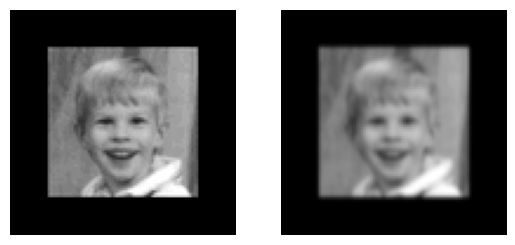

In [17]:
ym = tf.reshape(ym,  (1, 96, 96, 1))
x_train =  tf.reshape(x_train,  (1, 96, 96, 1))

plt.subplots(1, 2)

plt.subplot(1, 2, 1)
plt.imshow(x_train[0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ym[0], cmap='gray')
plt.axis('off')


In [22]:
model = keras.Sequential(
    [
        layers.Input(shape=(96, 96, 1)),
        DeconvDft2dLayer((2, 2)),
    ]
)

model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.SGD(),
)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 deconv_dft2d_layer_4 (Decon  (None, 96, 96, 1)        3         
 vDft2dLayer)                                                    
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(x_train, ym, epochs=10)

Epoch 1/10
1/1 [==============================] - 0s 67ms/step - loss: 798141.0000
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 798141.0000
Epoch 3/10
1/1 [==============================] - 0s 71ms/step - loss: 798141.0000
Epoch 4/10
1/1 [==============================] - 0s 71ms/step - loss: 798141.0000
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 798141.0000
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 798141.0000
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 798141.0000
Epoch 8/10
1/1 [==============================] - 0s 64ms/step - loss: 798141.0000
Epoch 9/10
1/1 [==============================] - 0s 69ms/step - loss: 798141.0000
Epoch 10/10
1/1 [==============================] - 0s 67ms/step - loss: 798141.0000


(-0.5, 95.5, 95.5, -0.5)

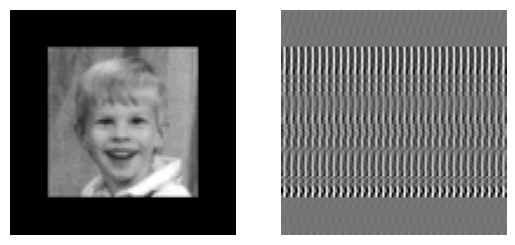

In [29]:
out = model.predict(x_train)
out.shape

plt.subplots(1, 2)

plt.subplot(1, 2, 1)
plt.imshow(x_train[0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(out[0], cmap='gray')
plt.axis('off')